In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

plt.rcParams["figure.dpi"] = 120


In [2]:
CSV_PATH = "covid_19_clean_complete.csv"   # taruh CSV di folder yang sama
COUNTRY = "Indonesia"                     # ganti sesuai kebutuhan
SCALE = 1000.0                            # skala pembagi (100 / 1000 / 10000)
START_DATE = None                         # contoh: "2020-03-01"
END_DATE = None                           # contoh: "2021-12-31"
FIT_SUBSAMPLE_STEP = 2                    # 1=pakai semua hari, 2=selang 2 hari, dst
MAXITER = 300


In [3]:
if not os.path.exists(CSV_PATH) and os.path.exists("/mnt/data/covid_19_clean_complete.csv"):
    CSV_PATH = "/mnt/data/covid_19_clean_complete.csv"

df = pd.read_csv(CSV_PATH)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print("CSV:", CSV_PATH)
print("Kolom:", df.columns.tolist())
print("Jumlah baris:", len(df))
df.head()


CSV: covid_19_clean_complete.csv
Kolom: ['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'WHO Region']
Jumlah baris: 49068


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [4]:
countries = sorted(df["Country/Region"].dropna().unique().tolist())
print("Jumlah negara:", len(countries))

if COUNTRY not in countries:
    print("COUNTRY tidak ditemukan, pakai negara pertama:", countries[0])
    COUNTRY = countries[0]

print("Negara terpilih:", COUNTRY)


Jumlah negara: 187
Negara terpilih: Indonesia


In [5]:
# agregasi per tanggal (sum semua province/state)
ts = (df[df["Country/Region"] == COUNTRY]
      .groupby("Date", as_index=False)[["Confirmed", "Deaths", "Recovered", "Active"]].sum()
      .sort_values("Date")
      .reset_index(drop=True))

# kalau ada NaN
for c in ["Confirmed", "Deaths", "Recovered", "Active"]:
    ts[c] = ts[c].fillna(0)

# kumulatif -> harian
ts["new_confirmed"] = ts["Confirmed"].diff().fillna(0)
ts["new_deaths"] = ts["Deaths"].diff().fillna(0)
ts["new_recovered"] = ts["Recovered"].diff().fillna(0)

# kadang ada koreksi data jadi negatif -> clip
for c in ["new_confirmed", "new_deaths", "new_recovered"]:
    ts[c] = ts[c].clip(lower=0)

# definisi variabel LV
ts["x_raw"] = ts["new_confirmed"]                            # prey proxy
ts["y_raw"] = ts["new_recovered"] + ts["new_deaths"]         # predator proxy (removal)

# buang awal yang masih 0 semua
ts = ts[(ts["x_raw"] > 0) | (ts["y_raw"] > 0)].reset_index(drop=True)

print("Range data:", ts["Date"].min().date(), "s.d.", ts["Date"].max().date())
print("Panjang series:", len(ts))
ts.head()


Range data: 2020-03-02 s.d. 2020-07-27
Panjang series: 143


,Date,Confirmed,Deaths,Recovered,Active,new_confirmed,new_deaths,new_recovered,x_raw,y_raw
0,2020-03-02,2,0,0,2,2.0,0.0,0.0,2.0,0.0
1,2020-03-06,4,0,0,4,2.0,0.0,0.0,2.0,0.0
2,2020-03-08,6,0,0,6,2.0,0.0,0.0,2.0,0.0
3,2020-03-09,19,0,0,19,13.0,0.0,0.0,13.0,0.0
4,2020-03-10,27,0,2,25,8.0,0.0,2.0,8.0,2.0


In [6]:
tsw = ts.copy()

if START_DATE is not None:
    tsw = tsw[tsw["Date"] >= pd.to_datetime(START_DATE)]
if END_DATE is not None:
    tsw = tsw[tsw["Date"] <= pd.to_datetime(END_DATE)]

tsw = tsw.reset_index(drop=True)

t = np.arange(len(tsw), dtype=float)          # waktu diskrit (hari)
x_obs = tsw["x_raw"].to_numpy(float) / SCALE
y_obs = tsw["y_raw"].to_numpy(float) / SCALE

# sesuai instruksi: nilai awal diambil dari hari pertama dataset
x0 = float(max(x_obs[0], 1e-6))
y0 = float(max(y_obs[0], 1e-6))

print("Window:", tsw["Date"].min().date(), "s.d.", tsw["Date"].max().date(), "| n =", len(tsw))
print("SCALE =", SCALE)
print("x0,y0 =", x0, y0)


Window: 2020-03-02 s.d. 2020-07-27 | n = 143
SCALE = 1000.0
x0,y0 = 0.002 1e-06


In [7]:
pd.DataFrame({
    "Date": tsw["Date"].head(5),
    "x(t)=new_confirmed/scale": x_obs[:5],
    "y(t)=new_removed/scale": y_obs[:5]
})


,Date,x(t)=new_confirmed/scale,y(t)=new_removed/scale
0,2020-03-02,0.002,0.000
1,2020-03-06,0.002,0.000
2,2020-03-08,0.002,0.000
3,2020-03-09,0.013,0.000
4,2020-03-10,0.008,0.002


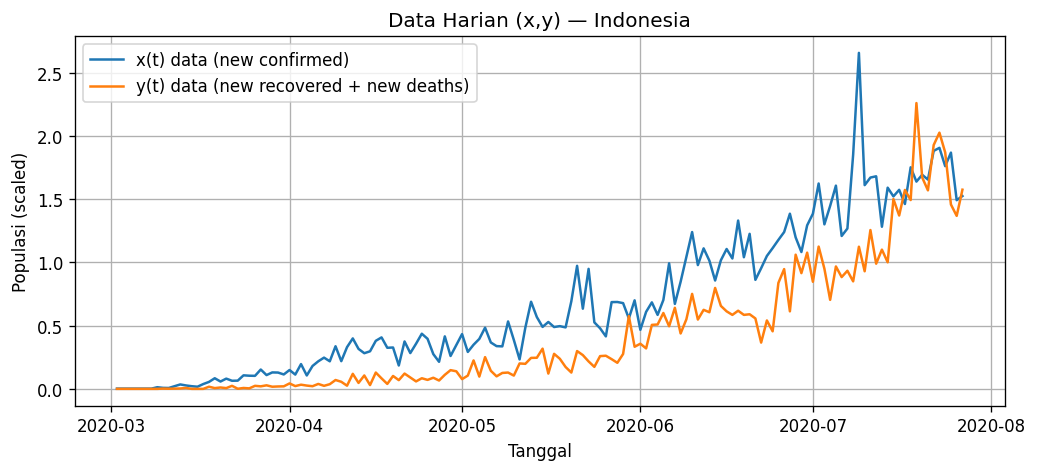

In [8]:
plt.figure(figsize=(10,4))
plt.plot(tsw["Date"], x_obs, label="x(t) data (new confirmed)")
plt.plot(tsw["Date"], y_obs, label="y(t) data (new recovered + new deaths)")
plt.xlabel("Tanggal")
plt.ylabel("Populasi (scaled)")
plt.title(f"Data Harian (x,y) — {COUNTRY}")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha*x - beta*x*y
    dydt = delta*x*y - gamma*y
    return [dxdt, dydt]

def simulate_lv(params, t_eval, x0, y0):
    alpha, beta, delta, gamma = params
    alpha = max(alpha, 1e-9)
    beta  = max(beta,  1e-9)
    delta = max(delta, 1e-9)
    gamma = max(gamma, 1e-9)

    sol = solve_ivp(
        fun=lambda tt, zz: lotka_volterra(tt, zz, alpha, beta, delta, gamma),
        t_span=(float(t_eval[0]), float(t_eval[-1])),
        y0=[x0, y0],
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-9
    )
    xs = np.clip(sol.y[0], 0, None)
    ys = np.clip(sol.y[1], 0, None)
    return xs, ys

def rmse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))


In [10]:
dx = np.diff(x_obs)
dy = np.diff(y_obs)

x_mid = x_obs[:-1]
y_mid = y_obs[:-1]
xy = x_mid * y_mid

# dx = alpha*x - beta*xy
A1 = np.column_stack([x_mid, -xy])
coef1, *_ = np.linalg.lstsq(A1, dx, rcond=None)
alpha0, beta0 = float(coef1[0]), float(coef1[1])

# dy = delta*xy - gamma*y
A2 = np.column_stack([xy, -y_mid])
coef2, *_ = np.linalg.lstsq(A2, dy, rcond=None)
delta0, gamma0 = float(coef2[0]), float(coef2[1])

# pastikan positif
p0 = np.array([
    max(alpha0, 1e-6),
    max(beta0,  1e-6),
    max(delta0, 1e-6),
    max(gamma0, 1e-6)
], dtype=float)

print("p0 [alpha, beta, delta, gamma] =", p0)


p0 [alpha, beta, delta, gamma] = [6.11431286e-04 1.30673185e-02 1.00000000e-06 3.92144203e-03]


In [11]:
step = int(max(1, FIT_SUBSAMPLE_STEP))
t_fit = t[::step]
x_fit = x_obs[::step]
y_fit = y_obs[::step]

def objective(log_params):
    params = np.exp(log_params)  # selalu positif
    try:
        xs, ys = simulate_lv(params, t_fit, x0, y0)
        return rmse(xs, x_fit) + rmse(ys, y_fit)
    except Exception:
        return 1e9

res = minimize(
    objective,
    np.log(p0),
    method="L-BFGS-B",
    options={"maxiter": int(MAXITER)}
)

p_best = np.exp(res.x)
print("Success:", res.success)
print("Message:", res.message)
print("p_best [alpha, beta, delta, gamma] =", p_best)


Success: True
Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
p_best [alpha, beta, delta, gamma] = [5.07189153e-02 1.30673179e-02 1.00000000e-06 3.88959595e-03]


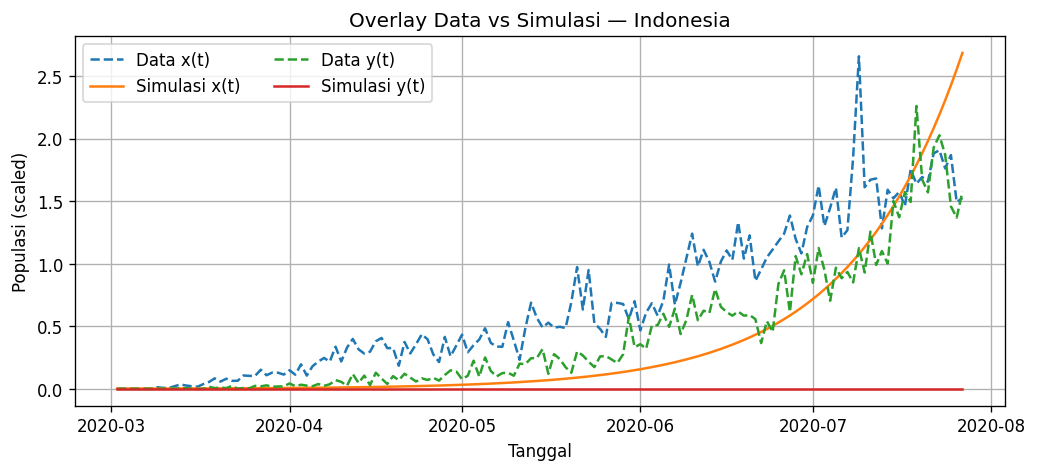

RMSE x: 0.4754976910731432
RMSE y: 0.6755719428553081


In [12]:
x_sim, y_sim = simulate_lv(p_best, t, x0, y0)

plt.figure(figsize=(10,4))
plt.plot(tsw["Date"], x_obs, "--", label="Data x(t)")
plt.plot(tsw["Date"], x_sim, "-", label="Simulasi x(t)")

plt.plot(tsw["Date"], y_obs, "--", label="Data y(t)")
plt.plot(tsw["Date"], y_sim, "-", label="Simulasi y(t)")

plt.xlabel("Tanggal")
plt.ylabel("Populasi (scaled)")
plt.title(f"Overlay Data vs Simulasi — {COUNTRY}")
plt.legend(ncol=2)
plt.grid(True)
plt.show()

print("RMSE x:", rmse(x_sim, x_obs))
print("RMSE y:", rmse(y_sim, y_obs))


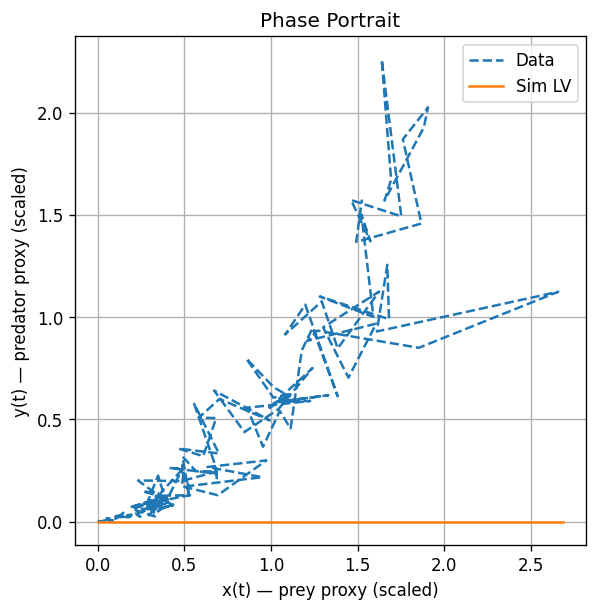

In [13]:
plt.figure(figsize=(5.5,5.5))
plt.plot(x_obs, y_obs, "--", label="Data")
plt.plot(x_sim, y_sim, "-", label="Sim LV")
plt.xlabel("x(t) — prey proxy (scaled)")
plt.ylabel("y(t) — predator proxy (scaled)")
plt.title("Phase Portrait")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
alpha, beta, delta, gamma = [float(v) for v in p_best]

x_star = gamma / delta
y_star = alpha / beta
print("Equilibrium (x*, y*) =", (x_star, y_star))

J = np.array([
    [alpha - beta*y_star, -beta*x_star],
    [delta*y_star,        delta*x_star - gamma]
], dtype=float)

eigvals = np.linalg.eigvals(J)
print("Jacobian di equilibrium:\n", J)
print("Eigenvalues:", eigvals)


Equilibrium (x*, y*) = (3889.595945231992, 3.881356206759125)
Jacobian di equilibrium:
 [[ 0.00000000e+00 -5.08265866e+01]
 [ 3.88135621e-06  0.00000000e+00]]
Eigenvalues: [0.+0.0140455j 0.-0.0140455j]
